In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

<h3>Task 1</h3>

In [2]:
x = np.array([4.17, 5.58, 5.18, 6.11, 4.5, 4.61, 5.17, 4.53, 5.33, 5.14])
y = np.array([6.31, 5.12, 5.54, 5.5, 5.37, 5.29, 4.92, 6.15, 5.8, 5.26])

In [3]:
df = pd.DataFrame({
    'ctrl': x,
    'trt': y
})

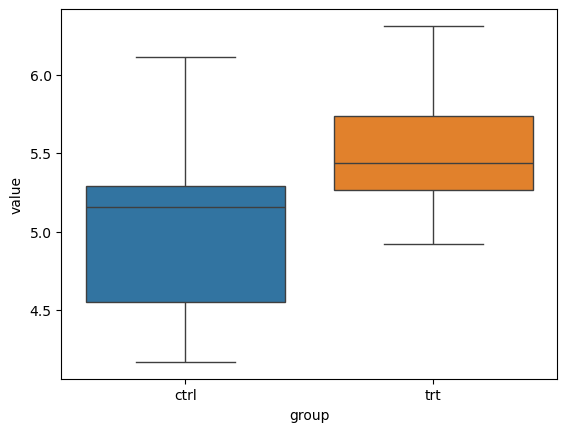

In [4]:
sns.boxplot(df)
plt.xlabel('group')
plt.ylabel('value');

As it is not explicitly stated that what the alternative hypothesis should be, we will use the safer and more conservative option; a two-sided alternative hypothesis.

$$
\begin{aligned}
\text{H}_0 &: \mu_1 = \mu_2 \\
\text{H}_1 &: \mu_1 \ne \mu_2
\end{aligned}
$$

In [5]:
print(np.var(x))
print(np.var(y))

0.305996
0.17628399999999997


- Assuming equal variances is not plausible.
- Hence, we will use [Welch's *t*-test](https://en.wikipedia.org/wiki/Welch%27s_t-test):

\begin{equation*}
    \large t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}.
\end{equation*}

In [6]:
def t_stat(x1, x2):
    mu1 = np.mean(x1)
    mu2 = np.mean(x2)
    s1 = np.var(x1, ddof=1)
    s2 = np.var(x2, ddof=1)
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    return (mu1 - mu2) / np.sqrt((s1 / n1) + (s2 / n2))

In [7]:
def permute(x, y, n):
    xy = np.concatenate([x,y], axis=0)
    n1 = x.shape[0]
    n12 = xy.shape[0]
    test_stats = []
    for i in range(n):
        xy_permuted = np.random.permutation(xy)
        x1 = xy_permuted[:x.shape[0]]
        x2 = xy_permuted[x.shape[0]:xy.shape[0]]
        stat = t_stat(x1=x1, x2=x2)
        test_stats.append(stat)
    return test_stats

In [8]:
# SciPy (traditional t-test approach)
ttest_ind(x, y, alternative='two-sided', equal_var=False)

TtestResult(statistic=np.float64(-2.1340204531240654), pvalue=np.float64(0.047899255601968935), df=np.float64(16.785764482605718))

In [13]:
# Permutation test
stat_sample = permute(x, y, n=10000)
print(f'P-value: {np.mean(np.abs(stat_sample) >= np.abs(t_stat(x,y)))}')

P-value: 0.044


- Since the p-value is smaller than the conventionally used significance level $\, \alpha = 0.05, \,$ one can reject the null hypothesis and conclude that the treatment effect is statistically significant.

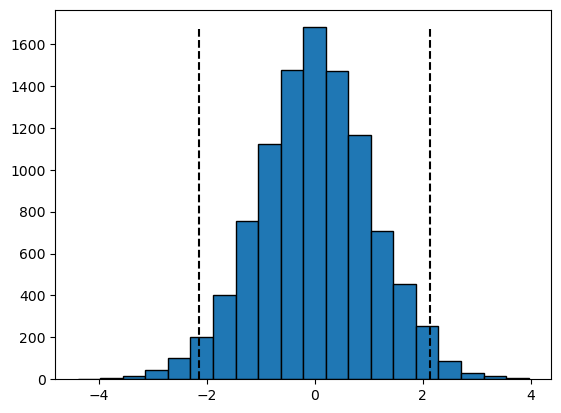

In [14]:
counts, _, _ = plt.hist(stat_sample, bins=20, edgecolor='black')
plt.vlines(x=t_stat(x,y), ymin=0, ymax=np.max(counts), linestyle='dashed', color='k')
plt.vlines(x=-t_stat(x,y), ymin=0, ymax=np.max(counts), linestyle='dashed', color='k');

A p-value is the probability of observing a test statistic as extreme or more extreme than the one obtained from the sample at hand, assuming that the null hypothesis is true. This translates to the following proportion

\begin{equation*}
    \text{P}(\text{T} \ge |\text{t}_{\text{obs}}|) \, + \, \text{P}(\text{T} \le -|\text{t}_{\text{obs}}|) = \frac{1}{n}\sum_{i=1}^{n} I(T_i \ge |t|) \, + \, \frac{1}{n}\sum_{i=1}^{n} I(T_i \le -|t|) = \frac{1}{n} \sum_{i=1}^{n} I(|T_i| \ge |\text{t}_{\text{obs}}|),
\end{equation*}

where $\, I(\cdot) \,$ is an indicator variable that is True if the expression inside of it is True, and False otherwise.

<h3>Task 2</h3>

In [15]:
def t(data):
    return np.mean(data)

In [16]:
def bootstrap(data, n, T):
    # Initialize an empty array to store the bs estimates
    bs_estimates = np.zeros(n)
    
    # Generate n bs samples,
    # compute the bs estimate from each bs sample,
    # store each bs estimate.
    for i in range(n):
        sample_indices = np.random.choice(a=data.shape[0], size=data.shape[0], replace=True)
        bs_estimates[i] = T(data[sample_indices])
        
    return bs_estimates

**a)**

In [29]:
bs_mean_x = bootstrap(data=x, n=10000, T=t)
bs_mean_y = bootstrap(data=y, n=10000, T=t)

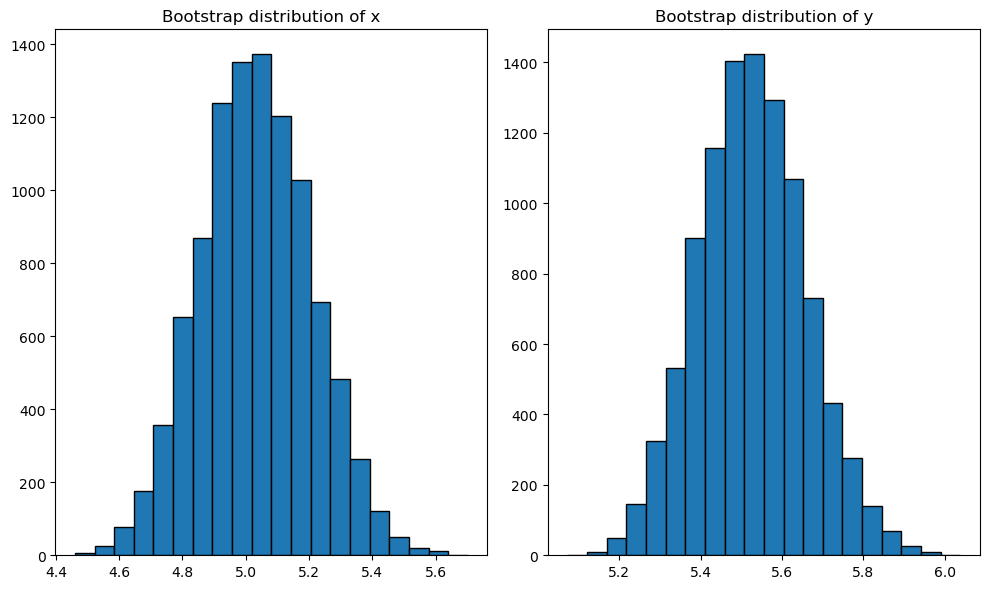

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
ax[0].hist(bs_mean_x, bins=20, edgecolor='black')
ax[0].set_title('Bootstrap distribution of x')
ax[1].hist(bs_mean_y, bins=20, edgecolor='black')
ax[1].set_title('Bootstrap distribution of y')
plt.tight_layout();

The *q*th percentile is the value below which at least q% of the data falls, including the values that are equal to it. The conficence interval using bootstrapping and the percentile method is simply the middle 95% of the values in the bootstrap distribution.

In [15]:
lower_bound_x, upper_bound_x = np.percentile(bs_mean_x, q=[2.5, 97.5])
lower_bound_y, upper_bound_y = np.percentile(bs_mean_y, q=[2.5, 97.5])

In [16]:
print('##### x #####')
print(f'The original estimator: {np.mean(x):.5f}')
print(f'The bootstrap estimator: {np.mean(bs_mean_x):.5f}')
print(f'The 95% CI for the mean: [{lower_bound_x:.5f}, {upper_bound_x:.5f}]')
print()
print('##### y #####')
print(f'The original estimator: {np.mean(y):.5f}')
print(f'The bootstrap estimator: {np.mean(bs_mean_y):.5f}')
print(f'The 95% CI for the mean: [{lower_bound_y:.5f}, {upper_bound_y:.5f}]')

##### x #####
The original estimator: 5.03200
The bootstrap estimator: 5.03274
The 95% CI for the mean: [4.69600, 5.38000]

##### y #####
The original estimator: 5.52600
The bootstrap estimator: 5.52487
The 95% CI for the mean: [5.27900, 5.79800]


**b)**

In [21]:
def bootstrap_mean_diff(x, y, n, T):
    bs_estimates = np.zeros(n)
    for i in range(n):
        sample_ind_x = np.random.choice(a=x.shape[0], size=x.shape[0], replace=True)
        sample_ind_y = np.random.choice(a=y.shape[0], size=y.shape[0], replace=True)
        mean_x = T(x[sample_ind_x])
        mean_y = T(y[sample_ind_y])
        bs_estimates[i] = mean_x - mean_y
    return bs_estimates

In [30]:
bs_diff_means = bootstrap_mean_diff(x, y, n=100000, T=t)

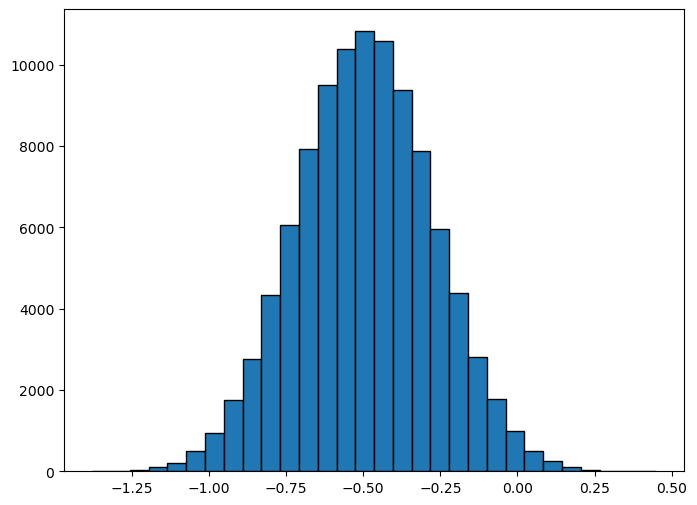

In [31]:
plt.figure(figsize=(8,6))
plt.hist(bs_diff_means, bins=30, edgecolor='black');

In [34]:
lower_bound_diff, upper_bound_diff = np.percentile(bs_diff_means, q=[2.5, 97.5])

In [35]:
print(f'The original estimator: {np.mean(x - y):.4f}')
print(f'The bootstrap estimator: {np.mean(bs_diff_means):.4f}')
print(f'The 95% CI for the mean: [{lower_bound_diff:.4f}, {upper_bound_diff:.4f}]')

The original estimator: -0.4940
The bootstrap estimator: -0.4949
The 95% CI for the mean: [-0.9240, -0.0620]


- As can be seen, the interval does not contain zero.